**1. Загрузка данных и предварительный анализ**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Загружаем набор данных
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Посмотрим на данные
print("Размер датасета:", X.shape)
print("Информация о пропусках:")
print(X.isnull().sum())

Размер датасета: (150, 4)
Информация о пропусках:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


**2. Разделение выборки на обучающую и тестовую**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**3. Обучение исходной модели с произвольным K**

In [4]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Оценка качества исходной модели
y_pred = knn.predict(X_test_scaled)
initial_accuracy = accuracy_score(y_test, y_pred)

print(f"Точность исходной модели (K={k}): {initial_accuracy:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

Точность исходной модели (K=5): 0.9333

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



**4. Подбор оптимального значения K с использованием GridSearchCV**

In [5]:
param_grid = {'n_neighbors': range(1, 31)}

# Стратегии кросс-валидации
cv_strategies = [
    ('KFold', KFold(n_splits=5, shuffle=True, random_state=42)),
    ('StratifiedKFold', StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

# Подбор гиперпараметров с GridSearchCV
grid_results = {}

for cv_name, cv in cv_strategies:
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_k = grid_search.best_params_['n_neighbors']
    best_score = grid_search.best_score_
    
    # Оценка оптимальной модели
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    grid_results[cv_name] = {
        'best_k': best_k,
        'best_cv_accuracy': best_score,
        'test_accuracy': accuracy
    }
    
    print(f"\nGridSearchCV с {cv_name}:")
    print(f"Оптимальное K: {best_k}")
    print(f"Точность на валидационной выборке: {best_score:.4f}")
    print(f"Точность на тестовой выборке: {accuracy:.4f}")


GridSearchCV с KFold:
Оптимальное K: 3
Точность на валидационной выборке: 0.9667
Точность на тестовой выборке: 0.9333

GridSearchCV с StratifiedKFold:
Оптимальное K: 3
Точность на валидационной выборке: 0.9667
Точность на тестовой выборке: 0.9333


**5. Подбор оптимального значения K с использованием RandomizedSearchCV**

In [6]:
random_results = {}

for cv_name, cv in cv_strategies:
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions={'n_neighbors': list(range(1, 31))},
        n_iter=10,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)
    
    best_k = random_search.best_params_['n_neighbors']
    best_score = random_search.best_score_
    
    # Оценка оптимальной модели
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    random_results[cv_name] = {
        'best_k': best_k,
        'best_cv_accuracy': best_score,
        'test_accuracy': accuracy
    }
    
    print(f"\nRandomizedSearchCV с {cv_name}:")
    print(f"Оптимальное K: {best_k}")
    print(f"Точность на валидационной выборке: {best_score:.4f}")
    print(f"Точность на тестовой выборке: {accuracy:.4f}")


RandomizedSearchCV с KFold:
Оптимальное K: 9
Точность на валидационной выборке: 0.9500
Точность на тестовой выборке: 0.9667

RandomizedSearchCV с StratifiedKFold:
Оптимальное K: 10
Точность на валидационной выборке: 0.9583
Точность на тестовой выборке: 0.9667


**6. Сравнение качества исходной и оптимальной моделей**


=== Сравнение моделей ===
Исходная модель (K=5):
Точность: 0.9333

Оптимальные модели из GridSearchCV:
  KFold (K=3):
  Точность: 0.9333
  StratifiedKFold (K=3):
  Точность: 0.9333

Оптимальные модели из RandomizedSearchCV:
  KFold (K=9):
  Точность: 0.9667
  StratifiedKFold (K=10):
  Точность: 0.9667


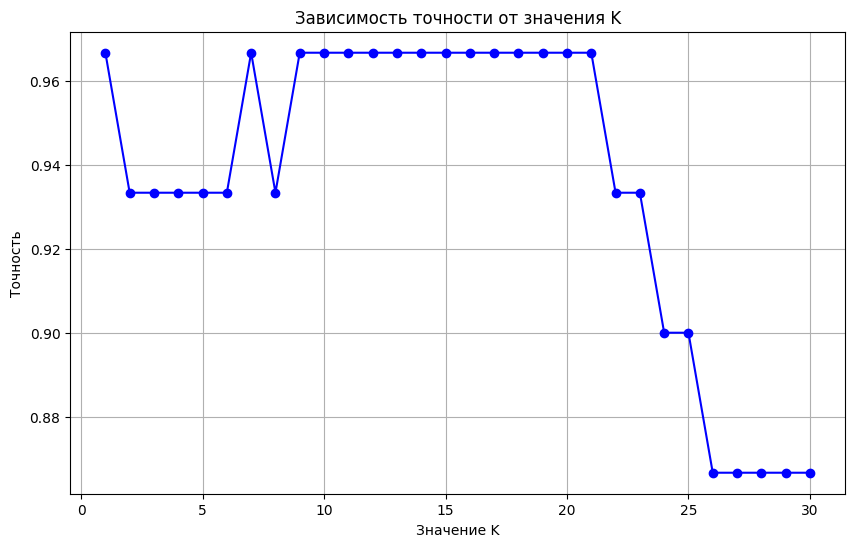

In [7]:
print("\n=== Сравнение моделей ===")
print(f"Исходная модель (K={k}):")
print(f"Точность: {initial_accuracy:.4f}")

print("\nОптимальные модели из GridSearchCV:")
for cv_name, results in grid_results.items():
    print(f"  {cv_name} (K={results['best_k']}):")
    print(f"  Точность: {results['test_accuracy']:.4f}")

print("\nОптимальные модели из RandomizedSearchCV:")
for cv_name, results in random_results.items():
    print(f"  {cv_name} (K={results['best_k']}):")
    print(f"  Точность: {results['test_accuracy']:.4f}")

# Визуализация зависимости точности от K
k_range = list(range(1, 31))
accuracy_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracy_scores, 'bo-')
plt.xlabel('Значение K')
plt.ylabel('Точность')
plt.title('Зависимость точности от значения K')
plt.grid(True)
plt.show()